In [51]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [269]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_samples=1000, n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

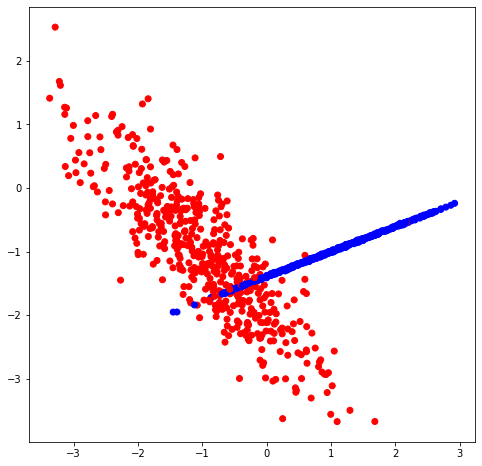

In [270]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [172]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [173]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction    

In [254]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

#task 2 - расчет критерия Энтропии
def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        if (p!= 0):         #при p=0 - 0log2(0)=0
            impurity += p * np.log(p)
        
    return -impurity

In [255]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):
    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

def quality_entropy(left_labels, right_labels, current_entropy):
    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_entropy - p * entropy(left_labels) - (1 - p) * entropy(right_labels)

In [241]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [242]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, quality_fun=quality):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality_fun(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [244]:
# Построение дерева с помощью рекурсивной функции
#task 1

def build_tree(data, labels, depth=0, max_depth=0, max_leaves=0, leaves_cnt=0, quality_fun=quality):

    quality, t, index = find_best_split(data, labels, quality_fun)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    if (max_leaves):
        if (leaves_cnt >= max_leaves):
            return Leaf(data, labels)
        leaves_cnt += 1
    
    if (max_depth):
        if (depth >= max_depth) :
            return Leaf(data, labels)
        depth += 1
    
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, depth=depth,
                             max_depth=max_depth, max_leaves=max_leaves, leaves_cnt=leaves_cnt)
    false_branch = build_tree(false_data, false_labels, depth=depth,
                             max_depth=max_depth, max_leaves=max_leaves, leaves_cnt=leaves_cnt)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [245]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [246]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [272]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [248]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, max_leaves=3, max_depth=3, quality_fun=quality)

In [219]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 1
Порог 0.13487041249253684
--> True:
  Индекс 0
  Порог -0.4658201109093335
  --> True:
    Индекс 1
    Порог -0.40663390905814234
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 0
  --> False:
    Индекс 0
    Порог -0.18029850901586197
    --> True:
      Прогноз: 1
    --> False:
      Прогноз: 1
--> False:
  Индекс 0
  Порог -0.5862310572574423
  --> True:
    Индекс 0
    Порог -1.0907562624079064
    --> True:
      Прогноз: 1
    --> False:
      Прогноз: 1
  --> False:
    Индекс 1
    Порог 0.6337976024858232
    --> True:
      Прогноз: 1
    --> False:
      Прогноз: 1


In [220]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [221]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [222]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [223]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

90.71428571428571

In [224]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

91.25

Text(0.5, 1.0, 'Test accuracy=91.25')

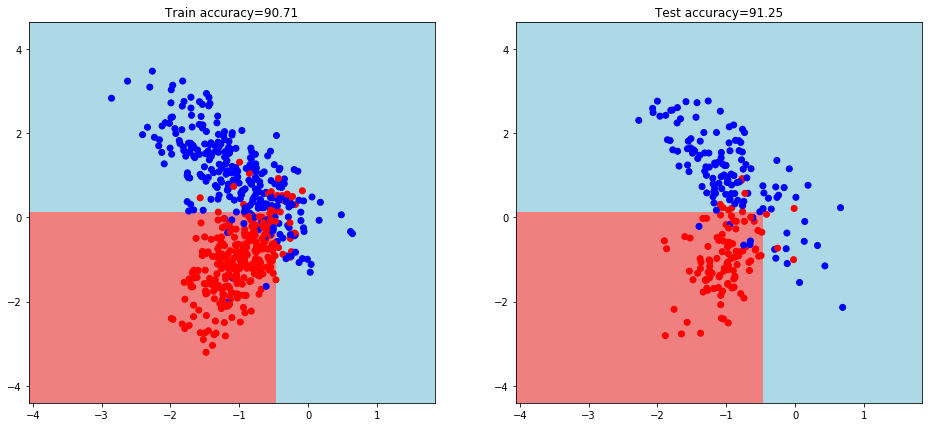

In [225]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

In [261]:

#task 2
# Построим дерево по обучающей выборке
my_tree_gini = build_tree(train_data, train_labels, max_depth=3, quality_fun=quality) #Джини
my_tree_entropy = build_tree(train_data, train_labels, max_depth=3, quality_fun=quality_entropy) #Энтропия
# print_tree(my_tree_gini)
# print_tree(my_tree_entropy)

Индекс 1
Порог 0.13487041249253684
--> True:
  Индекс 0
  Порог -0.4658201109093335
  --> True:
    Индекс 1
    Порог -0.40663390905814234
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 0
  --> False:
    Индекс 0
    Порог -0.18029850901586197
    --> True:
      Прогноз: 1
    --> False:
      Прогноз: 1
--> False:
  Индекс 0
  Порог -0.5862310572574423
  --> True:
    Индекс 0
    Порог -1.0907562624079064
    --> True:
      Прогноз: 1
    --> False:
      Прогноз: 1
  --> False:
    Индекс 1
    Порог 0.6337976024858232
    --> True:
      Прогноз: 1
    --> False:
      Прогноз: 1
Индекс 1
Порог 0.13487041249253684
--> True:
  Индекс 0
  Порог -0.4658201109093335
  --> True:
    Индекс 1
    Порог -0.40663390905814234
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 0
  --> False:
    Индекс 0
    Порог -0.18029850901586197
    --> True:
      Прогноз: 1
    --> False:
      Прогноз: 1
--> False:
  Индекс 0
  Порог -0.5862310572574423
  --> True:
    Ин

In [262]:
# Получим ответы для обучающей выборки
train_answers_gini = predict(train_data, my_tree_gini)
train_answers_entropy = predict(train_data, my_tree_entropy)
# И получим ответы для тестовой выборки
answers_gini = predict(test_data, my_tree_gini)
answers_entropy = predict(test_data, my_tree_entropy)


In [263]:
# Точность на обучающей выборке
train_accuracy_gini = accuracy_metric(train_labels, train_answers_gini)
train_accuracy_entropy = accuracy_metric(train_labels, train_answers_entropy)
# Точность на тестовой выборке
test_accuracy_gini = accuracy_metric(test_labels, answers_gini)
test_accuracy_entropy = accuracy_metric(test_labels, answers_entropy)
print("Точность Джини на обучающей выборке: " + str(train_accuracy_gini))
print("Точность Энтропии на обучающей выборке: " + str(train_accuracy_entropy))
print("Точность Джини на тестовой выборке: " + str(test_accuracy_gini))
print("Точность Энтропии на тестовой выборке: " + str(test_accuracy_entropy))

Точность Джини на обучающей выборке: 90.71428571428571
Точность Энтропии на обучающей выборке: 90.71428571428571
Точность Джини на тестовой выборке: 91.25
Точность Энтропии на тестовой выборке: 91.25


In [273]:
def compare_methods(max_depth=0):
    my_tree_gini = build_tree(train_data, train_labels, max_depth=max_depth, quality_fun=quality) #Джини
    my_tree_entropy = build_tree(train_data, train_labels, max_depth=max_depth, quality_fun=quality_entropy) #Энтропия
    # print_tree(my_tree_gini)
    # print_tree(my_tree_entropy)
    # Получим ответы для обучающей выборки
    train_answers_gini = predict(train_data, my_tree_gini)
    train_answers_entropy = predict(train_data, my_tree_entropy)
    # И получим ответы для тестовой выборки
    answers_gini = predict(test_data, my_tree_gini)
    answers_entropy = predict(test_data, my_tree_entropy)
    # Точность на обучающей выборке
    train_accuracy_gini = accuracy_metric(train_labels, train_answers_gini)
    train_accuracy_entropy = accuracy_metric(train_labels, train_answers_entropy)
    # Точность на тестовой выборке
    test_accuracy_gini = accuracy_metric(test_labels, answers_gini)
    test_accuracy_entropy = accuracy_metric(test_labels, answers_entropy)
    #вывод результата
    print("Максимальная глубина: " + str(max_depth))
    print("Точность Джини на обучающей выборке: " + str(train_accuracy_gini))
    print("Точность Энтропии на обучающей выборке: " + str(train_accuracy_entropy))
    print("Точность Джини на тестовой выборке: " + str(test_accuracy_gini))
    print("Точность Энтропии на тестовой выборке: " + str(test_accuracy_entropy) + "\n\n")
    
depths = [0,1,2,3,5]
for d in (depths):
    compare_methods(d)

Максимальная глубина: 0
Точность Джини на обучающей выборке: 98.14285714285714
Точность Энтропии на обучающей выборке: 98.14285714285714
Точность Джини на тестовой выборке: 95.0
Точность Энтропии на тестовой выборке: 95.0


Максимальная глубина: 1
Точность Джини на обучающей выборке: 89.14285714285714
Точность Энтропии на обучающей выборке: 89.14285714285714
Точность Джини на тестовой выборке: 85.66666666666667
Точность Энтропии на тестовой выборке: 85.66666666666667


Максимальная глубина: 2
Точность Джини на обучающей выборке: 94.42857142857143
Точность Энтропии на обучающей выборке: 94.42857142857143
Точность Джини на тестовой выборке: 93.66666666666667
Точность Энтропии на тестовой выборке: 93.66666666666667


Максимальная глубина: 3
Точность Джини на обучающей выборке: 95.14285714285714
Точность Энтропии на обучающей выборке: 95.14285714285714
Точность Джини на тестовой выборке: 94.0
Точность Энтропии на тестовой выборке: 94.0


Максимальная глубина: 5
Точность Джини на обучающей 

In [ ]:
#оба критерия дают одинаковую точность результата